<h1><center> <font color='black'>  Network Science (LTAT.02.011) - Homework - 02  </font></center></h1>
<h2><center> <font color='black'> Echo Chambers and Text Representation in Network Science</font></center></h3>
<h2><center> <font color='black'> University of Tartu - 2024</font></center></h3>

================================================================================================================

# Homework instructions

- This homework should be done individually or in group of 2 (max).

- Please provide the names and student IDs of the team-members in the field "Student info" below. If you are not working in a team please insert only your name and student ID.

- Only one of the teammates should submit the homework. We will grade the homework and the marks and feedback is applied for both the team members. So please communicate with your team member about marks and feedback if you are submitting the homework.

- The accepted submission format is .ipynb file. Please upload the file on moodle.

- The submission will automatically close on **<font color='red'>17 April 2024 at 23:59 pm</font>**, so please make sure you have enough time to submit the homework.

- You do not necessarily need to work on Colab. Especially as the size and the complexity of datasets will increase through the course, you can install jupyter notebooks locally and work from there.

- If you do not understand what a question is asking for, please ask in Moodle.


**<h2><font color='red'>Student info:</font></h2>**


<font color='red'>Full name: </font> Kristjan Lõhmus

<font color='red'>Student ID: </font>B65854

# Installing and Importing Libraries

In [1]:
# Importing libraries
import pandas as pd
from nltk.corpus import stopwords
import nltk
from sentence_transformers import SentenceTransformer, util
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import community
from random_walk_controversy import get_rwc
from datasets import load_dataset
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer

pd.options.mode.copy_on_write = True

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KristjanLõhmus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KristjanLõhmus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# 1. News semantic matching and summarization

You are a data analyst for a media publishing company. The media publishing company keen on gaining insights from competitors by identifying news events covered by various publishing houses.

In addition, the media publishing company wishes that one news event is then summarized from the most important sentences. The company can use this information to better write their own report on the news event. The media publishing company has provided you with their collected news articles from competitors pages (ag_news dataset).

## 1.1 Reading Data and Preprocessing (5 points)


Before working with the data we need to preprocess the data to remove unhelpful noise.

Let us first read in the data. This has been done for you.

In [2]:
dataset = load_dataset("ag_news")
data = pd.DataFrame(dataset['train'])

data = data.rename(columns={'text': 'Article'})

data.head()

,Article,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2


In [3]:
# Lets drop columns we do not need

news = data[["Article"]]

In [4]:
print('Dataset dimension:', news.shape)

Dataset dimension: (120000, 1)


In [5]:
news.head()

,Article
0,Wall St. Bears Claw Back Into the Black (Reute...
1,Carlyle Looks Toward Commercial Aerospace (Reu...
2,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,Iraq Halts Oil Exports from Main Southern Pipe...
4,"Oil prices soar to all-time record, posing new..."


In [6]:
news['Article'] = news['Article'].apply(str)
news['Article_length'] = news['Article'].apply(len)

print(f"Maximum article length: {news['Article_length'].max()}")
print(f"Minimum article length: {news['Article_length'].min()}")

Maximum article length: 1012
Minimum article length: 100


**1.1.1. Semantic similarity calculation works best if we have texts that are relatively similar in length. From the cell above we can see that some articles are too short or too long to be accurately matched. Let us include into our dataset only articles, that are longer than 150 chars and shorter than 200 chars.**

In [7]:
filtered_news = news[(news['Article_length'] < 200) & (news['Article_length'] > 150)]
# Use this to check that your code did the required change
print(f"Maximum article length in filtered dataset: {filtered_news['Article_length'].max()}")
print(f"Minimum article length in filtered dataset: {filtered_news['Article_length'].min()}")
print('Dataset dimension:', filtered_news.shape)

Maximum article length in filtered dataset: 199
Minimum article length in filtered dataset: 151
Dataset dimension: (25046, 2)


**1.1.2. Create a new column for your preprocessed article text (we want to keep the original so that we can do summarization later).**

In [8]:
filtered_news["Preprocessed_article"] = filtered_news['Article']

**1.1.3. Lowercase the articles and count how many lines were changed**

In [9]:
filtered_news["Preprocessed_article"] = filtered_news["Preprocessed_article"].str.lower()
count_of_articles_with_uppercase_letters = sum(filtered_news["Article"] != filtered_news["Preprocessed_article"])
print(f"Count of articles that include some uppercase characters: {count_of_articles_with_uppercase_letters}")
filtered_news.head()

Count of articles that include some uppercase characters: 25046


,Article,Article_length,Preprocessed_article
18,US trade deficit swells in June The US trade d...,155,us trade deficit swells in june the us trade d...
19,Shell 'could be target for Total' Oil giant Sh...,155,shell 'could be target for total' oil giant sh...
20,Google IPO faces Playboy slip-up The bidding g...,171,google ipo faces playboy slip-up the bidding g...
21,Eurozone economy keeps growing Official figure...,161,eurozone economy keeps growing official figure...
23,Rand falls on shock SA rate cut Interest rates...,162,rand falls on shock sa rate cut interest rates...


**1.1.4. Remove all urls from the articles and count how many lines were changed**

In [10]:
pattern = r'(https?:\/\/(?:www\.)?[-a-zA-Z0-9@:%._+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}[-a-zA-Z0-9()@:%_+.~#?&/=]*)'
count_of_articles_with_urls = filtered_news["Preprocessed_article"].str.count(pattern).sum()
filtered_news["Preprocessed_article"] = filtered_news["Preprocessed_article"].str.replace(pattern, '')

print(f"Count of articles that include urls: {count_of_articles_with_urls}")
filtered_news.head()

Count of articles that include urls: 11


,Article,Article_length,Preprocessed_article
18,US trade deficit swells in June The US trade d...,155,us trade deficit swells in june the us trade d...
19,Shell 'could be target for Total' Oil giant Sh...,155,shell 'could be target for total' oil giant sh...
20,Google IPO faces Playboy slip-up The bidding g...,171,google ipo faces playboy slip-up the bidding g...
21,Eurozone economy keeps growing Official figure...,161,eurozone economy keeps growing official figure...
23,Rand falls on shock SA rate cut Interest rates...,162,rand falls on shock sa rate cut interest rates...


**1.1.5. Add one other pre-processing step of your choice and print the count of rows affected. Justify your choice for the pre-processing step.**

<font color='red'>How you should answer the following questions. First, in the `#TODO` cell you have to write the code representing your solution. And in the `Your answer` cell write the answer in your own words.</font>

In [11]:
def remove_stopwords(text):
    tokens = text.split()
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(filtered_tokens)
modified_articles = filtered_news["Preprocessed_article"].apply(remove_stopwords)
print(f'Number of modified rows {sum(modified_articles != filtered_news["Preprocessed_article"])}')
filtered_news["Preprocessed_article"] = modified_articles

Number of modified rows 25033


**<font color='red'>Your answer:</font>** Stopwords don't add much to the text, so removing them should make the analysis easier.

We will also reset the index to make working in exercise 2 a bit easier.

In [12]:
filtered_news.reset_index(drop=True, inplace=True)

## 1.2. Similarity calculation and graph creation (5 points)

**1.2.1. Load in a Sentence Transformers model (this is already given)**

In [13]:
model = SentenceTransformer('all-MiniLM-L6-v2')

**1.2.2. Calculate the embeddings on our pre-processed articles. Note this might take a long time (less than 10 minutes is expected though).**

In [14]:
embeddings = np.array(model.encode(filtered_news["Preprocessed_article"].tolist()))

**1.2.3. Calculate the cosine similarity between the embeddings as a matrix (we recommend using the util.cos_sim function as it is faster than some others)**

In [15]:
cosine_sim_matrix = util.cos_sim(embeddings, embeddings)

In [16]:
cosine_sim_matrix

tensor([[ 1.0000,  0.1628,  0.0106,  ..., -0.0011, -0.0752, -0.0184],
        [ 0.1628,  1.0000,  0.0817,  ...,  0.0530, -0.0363,  0.0041],
        [ 0.0106,  0.0817,  1.0000,  ...,  0.0947, -0.0934,  0.0746],
        ...,
        [-0.0011,  0.0530,  0.0947,  ...,  1.0000,  0.1391,  0.0269],
        [-0.0752, -0.0363, -0.0934,  ...,  0.1391,  1.0000,  0.0210],
        [-0.0184,  0.0041,  0.0746,  ...,  0.0269,  0.0210,  1.0000]])

**1.2.4. Build the graph. Please use a similarity threshold of 0.85.**

Hint: Use numpy vectorized operations, otherwise this could take long (but its also fine if you use a simple for-loop).

In [17]:
threshold = 0.85
cosine_sim_matrix_copy = cosine_sim_matrix.numpy()
cosine_sim_matrix_copy[cosine_sim_matrix_copy <= threshold] = 0
G = nx.from_numpy_array(cosine_sim_matrix_copy)
nx.set_node_attributes(G, filtered_news["Preprocessed_article"].to_dict(), 'text')

**1.2.6. Plot the top 10 largest (with the most nodes) network components.**

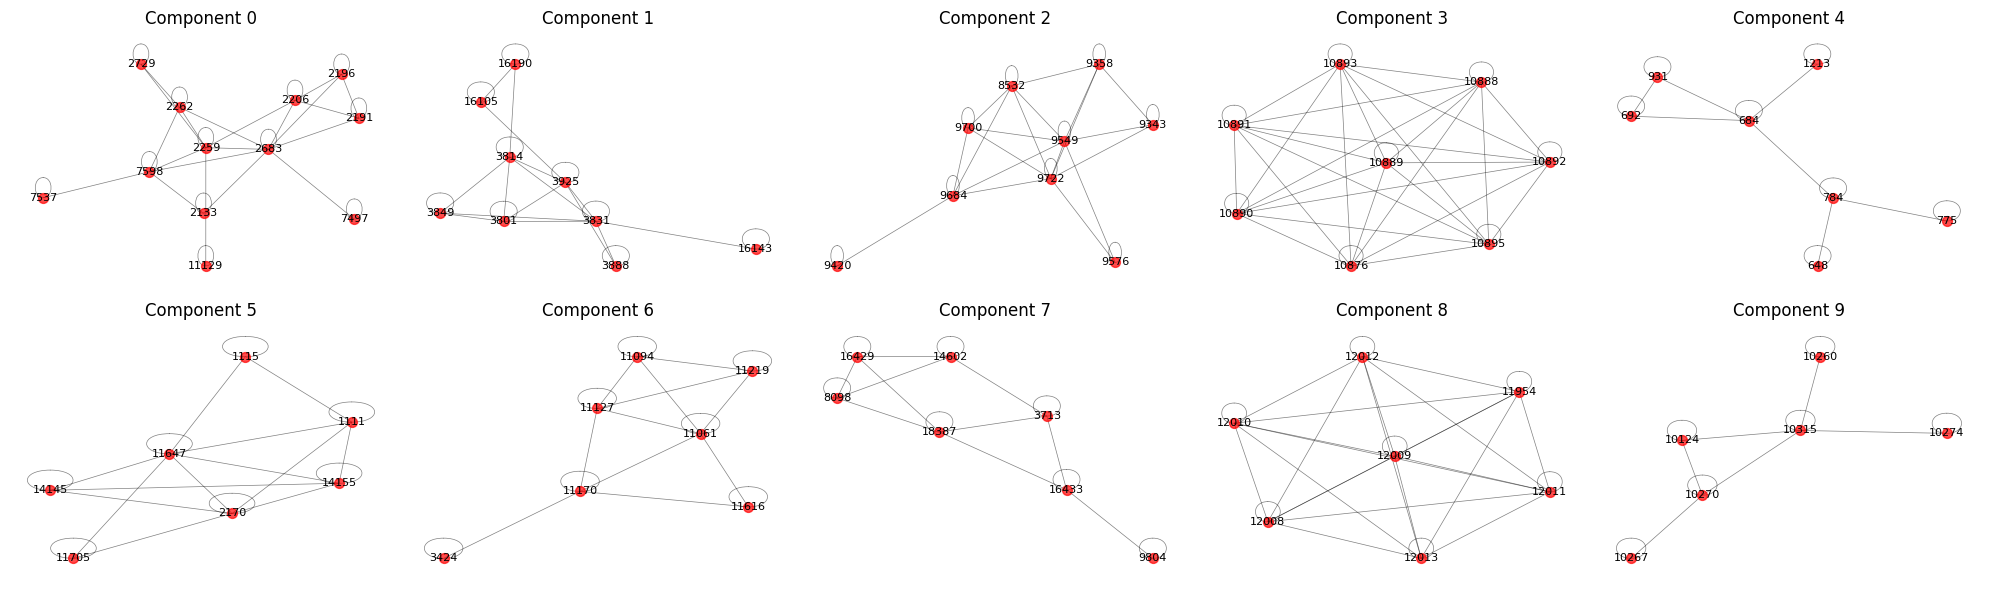

In [18]:
connected_components = sorted(nx.connected_components(G), key=len, reverse=True)
largest_components = [G.subgraph(c).copy() for c in connected_components[:10]]
fig, axes = plt.subplots(2, 5, figsize=(20, 6))
i = 0
j = 0
for k, component in enumerate(largest_components):
    pos = nx.spring_layout(component)
    nx.draw_networkx_nodes(component, pos, node_size=50, node_color='red', alpha=0.7, ax=axes[j][i])
    nx.draw_networkx_edges(component, pos, width=0.5, alpha=0.5, edge_color="black", ax=axes[j][i])
    nx.draw_networkx_labels(component, pos, font_size=8, ax=axes[j][i])
    axes[j][i].set_title(f'Component {k}')
    axes[j][i].axis('off')
    i +=1
    if i == 5:
        j += 1
        i = 0

plt.tight_layout()
plt.show()

**1.2.7. Print the articles of one component of your choice. Are these articles similar, meaning do they cover the same news event? Why/Why not?**

<font color='red'>How you should answer the following questions. First, in the `#TODO` cell you have to write the code representing your solution. And in the `Your answer` cell write the answer in your own words.</font>

In [19]:
largest_component = largest_components[0]
nx.get_node_attributes(largest_component, 'text')

{7497: 'oracle extends tender offer peoplesoft oracle corp. (orcl.o: quote, profile, research) , world #39;s second-biggest software company, thursday said extended \\$7.',
 2729: 'oracle re-extends peoplesoft bid oracle offering us\\$21 per share us\\$7.7 billion peoplesoft, leader human resources management software applications rival oracle.',
 7598: 'oracle extends peoplesoft offer oracle extended hostile bid peoplesoft 12th time, pushing tender offer october 8. oracle said press release 23.',
 2191: 'oracle extends offer peoplesoft oracle #39;s hostile bid acquire rival enterprise software maker peoplesoft \\$7.7bn (4.3bn) set continue bit longer.',
 7537: 'oracle extends peoplesoft offer (ap) ap - oracle corp. extended hostile bid peoplesoft inc. 12th time, pushing tender offer oct. 8.',
 2259: 'oracle extends bid peoplesoft oracle extended \\$21-per-share tender offer peoplesoft #39;s shareholders, due expire week. new deadline september 10th.',
 2196: "oracle extends offer peop

**<font color='red'>Your answer:</font>** The articles are similar and seem to cover everything Oracle buying PeopleSoft.

## 1.3. Summarization (5 points)

**1.3.1. Please extract all of the articles of one component of your choice.**

In [20]:
articles = [article for article in nx.get_node_attributes(largest_component, 'text').values()]
articles

['oracle extends tender offer peoplesoft oracle corp. (orcl.o: quote, profile, research) , world #39;s second-biggest software company, thursday said extended \\$7.',
 'oracle re-extends peoplesoft bid oracle offering us\\$21 per share us\\$7.7 billion peoplesoft, leader human resources management software applications rival oracle.',
 'oracle extends peoplesoft offer oracle extended hostile bid peoplesoft 12th time, pushing tender offer october 8. oracle said press release 23.',
 'oracle extends offer peoplesoft oracle #39;s hostile bid acquire rival enterprise software maker peoplesoft \\$7.7bn (4.3bn) set continue bit longer.',
 'oracle extends peoplesoft offer (ap) ap - oracle corp. extended hostile bid peoplesoft inc. 12th time, pushing tender offer oct. 8.',
 'oracle extends bid peoplesoft oracle extended \\$21-per-share tender offer peoplesoft #39;s shareholders, due expire week. new deadline september 10th.',
 "oracle extends offer peoplesoft oracle corp.'s hostile bid acquire 

**1.3.2. Now use LexRank to summarize those sentences. Your summary should compose of three sentences. Is your summary good? Why/Why not?**

<font color='red'>How you should answer the following questions. First, in the `#TODO` cell you have to write the code representing your solution. And in the `Your answer` cell write the answer in your own words.</font>

In [21]:
text = " ".join(articles)

parser = PlaintextParser.from_string(text, Tokenizer("english"))

summarizer = LexRankSummarizer()

summary_sentences = summarizer(parser.document, sentences_count=3)

summary = [str(sentence) for sentence in summary_sentences]

summary_text = " ".join(summary)

print("Summary:")
print(summary_text)

Summary:
oracle re-extends peoplesoft bid oracle offering us\$21 per share us\$7.7 billion peoplesoft, leader human resources management software applications rival oracle. oracle extends peoplesoft offer (ap) ap - oracle corp. extended hostile bid peoplesoft inc. 12th time, pushing tender offer oct. 8. oracle extends bid peoplesoft oracle extended \$21-per-share tender offer peoplesoft #39;s shareholders, due expire week. oracle extends offer peoplesoft san francisco -- business software maker oracle corp. said thursday extended \$7.7 billion hostile tender offer peoplesoft inc. oracle extends offer peoplesoft oracle corp. #39;s hostile bid acquire rival enterprise software maker peoplesoft inc. \$7.7 billion set continue bit longer.


**<font color='red'>Your answer:</font>** The articles are pretty similar and not too lengthy. This also shows in the summary, which repeats itself a lot. Maybe 1 sentence summary would be better

# 2. Homophily detection (5 points)

Your next task is to put yourself in the role of a data analyst of a book shop. This book shop sells books on American politics. The bookshop owner wishes to undestand if peoples political leaning influences which books they purchase. For you to analyse this, he has already categorized all of the books by political leaning (conservative, neutral and liberal) and marked down which books are copurchased frequently. One way we can analyse if political leaning plays a role in copurchasing patterns, is by looking at the homophily of the network. Luckily for you the bookshop owner has already made this data into a nice graph (polbooks dataset).

Let us first load in the prepared dataset.

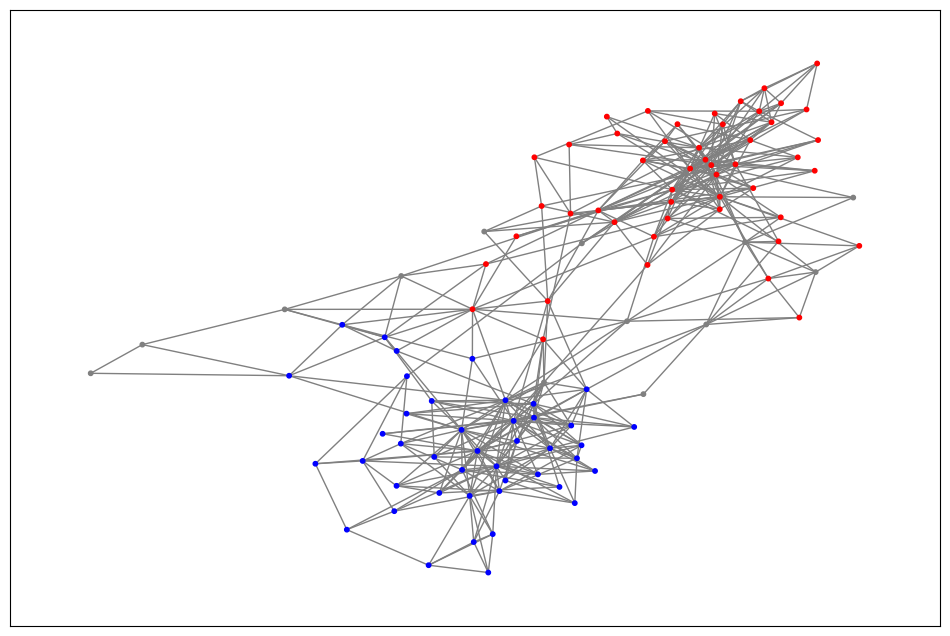

In [22]:
import networkx as nx
import matplotlib.pyplot as plt

color_map_polbooks = {'c': 'red', 'n': 'gray', 'l': 'blue'}
G_polbooks = nx.read_graphml('polbooks.xml')
node_colors_polbooks = [color_map_polbooks.get(G_polbooks.nodes[node]['value'], 'grey') for node in G_polbooks.nodes()]

plt.figure(figsize=(12, 8))
nx.draw_networkx(G_polbooks, node_size=10, with_labels=False, node_color=node_colors_polbooks, edge_color='gray')
plt.show()

**2.1. Calculate the E-I Index of the network. What can you say from the index score you get regarding homophily?**

<font color='red'>How you should answer the following questions. First, in the `#TODO` cell you have to write the code representing your solution. And in the `Your answer` cell write the answer in your own words.</font>

In [23]:
ET = 0
IT = 0

for edge in G_polbooks.edges():
    node_a, node_b = edge
    if G_polbooks.nodes[node_a]['value'] != G_polbooks.nodes[node_b]['value']:
        ET += 1
    else:
        IT += 1

EI_index = (ET - IT) / (ET + IT)
EI_index

-0.6825396825396826

**<font color='red'>Your answer:</font>** External-Internal index value of -0.68 shows that the network is dominated by homophily, meaning that books with same political agenda are frequently bought together.

**2.2. Calculate the modularity of the network. What can you say from the modularity score you get regarding homophily?**

<font color='red'>How you should answer the following questions. First, in the `#TODO` cell you have to write the code representing your solution. And in the `Your answer` cell write the answer in your own words.</font>

In [24]:
communities = {}
for node in G_polbooks.nodes(data=True):
    node_id, attr = node
    group = attr['value']
    if group not in communities:
        communities[group] = set()
    communities[group].add(node_id)

modularity_score = community.modularity(G_polbooks, list(communities.values()))
modularity_score

0.4149402769422207

**<font color='red'>Your answer:</font>** Community score of 0.41 also indicates that network is homophilious (not strongly, but still).

**2.3. Calculate the Random Walk Controversy of the network. What can you say from the RWC score you get regarding homophily?**

<font color='red'>How you should answer the following questions. First, in the `#TODO` cell you have to write the code representing your solution. And in the `Your answer` cell write the answer in your own words.</font>

In [25]:
left_nodes = [n for n, d in G_polbooks.nodes(data=True) if d['value'] == 'l']
right_nodes = [n for n, d in G_polbooks.nodes(data=True) if d['value'] == 'c']
node_percentage = 0.3
number_simulations = 1000
get_rwc(G_polbooks, left_nodes, right_nodes, node_percentage, number_simulations)

0.7597210211631547

**<font color='red'>Your answer:</font>** RWC value of 0.76 also indicates a pretty high degree of homophily.

**2.4. What conclusions can you make to the book shop owner based on your metrics? Is there are strong tendency to copurchase books from the same political leaning?**

**<font color='red'>Your answer:</font>** There is indeed a pretty strong tendency to copurchase books with a similar political agenda. For a more practical recommendation - the books with similar agenda should be grouped together in the store for a better chance of a customer buying multiple of those.

# How long did it take you to solve the homework?

* Please answer as precisely as you can. It does not affect your points or grade in any way. It is okay, if it took 0.5 hours or 24 hours. The collected information will be used to improve future homeworks. Please change X into your estimate.

<font color='red'> **Answer:**</font> 5 hours

# What is the level of difficulty for this homework?
Please put a number between $0:10$ ($0:$ easy, $10:$ difficult)

<font color='red'> **Answer:**</font> 5